In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n = 20
nx = n
ny = n
σ = 10   # spread of storm
γ = 0.95 # Discount Factor
x_eye = np.array([15, 14]) #(y, x)

x_goal = np.array([9, 19]) #(y, x)



grid = np.zeros((ny, nx))

ω = lambda x:  np.exp(-np.linalg.norm(np.array(x) - x_eye, 2)**2 / (2*σ**2))
ω_grid = grid
for y in range(grid.shape[0]):
    for x in range(grid.shape[1]):
        ω_grid[y,x]  = ω([y,x])
ω_grid = ω_grid # the indices need to be transposed because moving to the right is actually moving through columns

In [3]:
ω_grid[9, 19]

0.7371233743916278

Text(0.5, 1.0, 'Storm Influence')

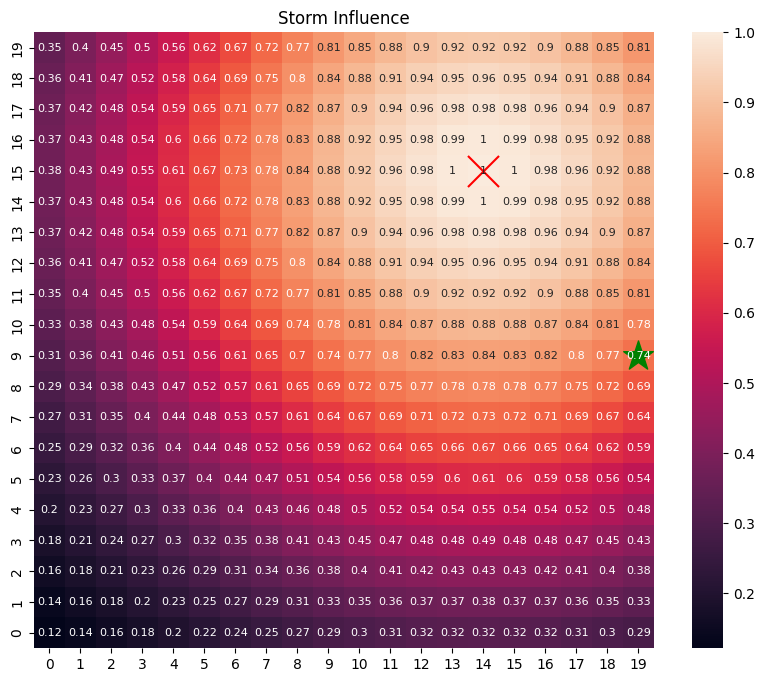

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ω_grid, annot=True, annot_kws={'fontsize':8}, ax=ax)
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='r', marker='x', label='Storm Eye')
ax.invert_yaxis()
ax.set_title('Storm Influence')
# ax.legend()

In [5]:
# define actions
act = {
    3: np.array([0, 1]),    #  right (y, x) 
    0: np.array([1, 0]),    #  up (y, x)
    2: np.array([0, -1]),   #  left (y, x)
    1: np.array([-1, 0])    #  down (y, x)
}

def action_dynamics(x:np.array, a:int):
    # x: (y, x)

    if x[0] >= ny or x[1] >= nx:
        print(x)
        raise ValueError('Outside of Boundary')

    x_next = x + act[a]

    if x_next[0] < 0:
        # print('edge')
        x_next[0] = 0
    elif x_next[0] > ny-1:
        # print('edge')
        x_next[0] = ny-1

    if x_next[1] < 0:
        # print('edge')
        x_next[1] = 0
    elif x_next[1] > nx-1:
        # print('edge')
        x_next[1] = nx-1

    return x_next

# define dynamic rule for each step
def dynamics(x:np.array, a:int, ω_grid:np.array, n:int):
    prob = np.random.rand(1)

    # print(x)
    if prob < ω_grid[*x]:
        # print('storm')
        a = np.random.randint(0, 4,)

    x_next = action_dynamics(x, a)
        
    
    return x_next

# store value iter as 3d vector

In [8]:
x0 = np.array([0, 0])
list_a = [0]*30

x_trj = np.zeros((len(list_a)+1, x0.shape[0]), dtype=int)
x_trj[0] = x0
for i, a in enumerate(list_a):
    x_trj[i+1,:] = dynamics(x_trj[i,:], 0, ω_grid, n) 
# x_trj

Text(0.5, 1.0, 'Storm Influence')

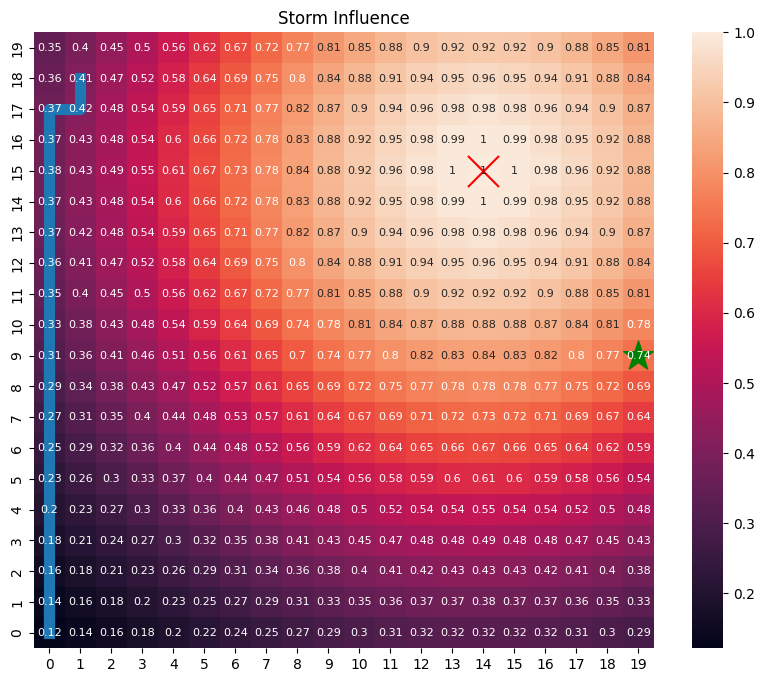

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ω_grid, annot=True, annot_kws={'fontsize':8}, ax=ax)
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='r', marker='x', label='Storm Eye')
ax.plot(x_trj[:,1]+0.5, x_trj[:,0]+0.5, linewidth=8)
ax.invert_yaxis()
ax.set_title('Storm Influence')
# ax.legend()

In [10]:
# ω_grid[0, 20]

Text(0.5, 1.0, 'Reward Function')

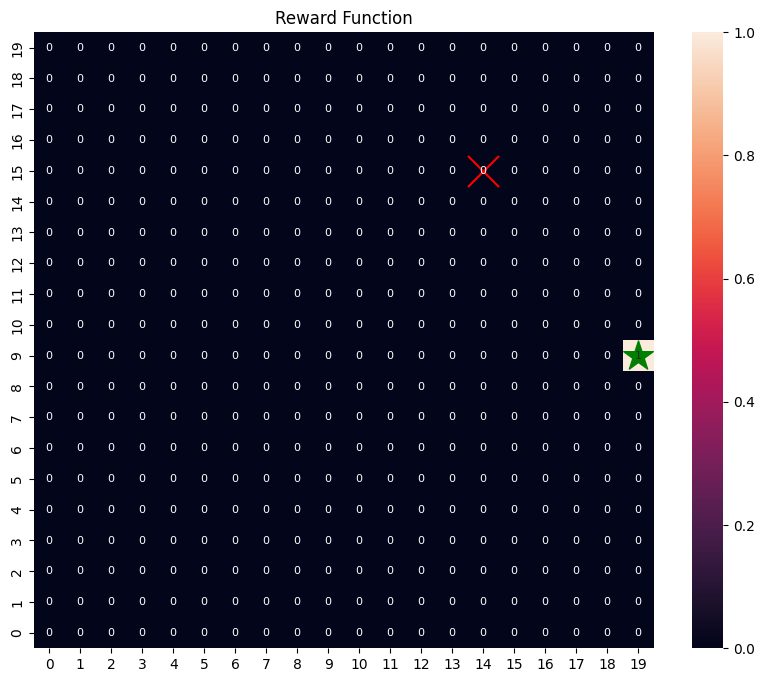

In [11]:
R_grid = np.zeros((ny, nx))
R_grid[*x_goal] = 1 
# R_grid = R_grid.T # the indices need to be transposed because moving to the right is actually moving through columns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(R_grid, annot=True, annot_kws={'fontsize':8}, ax=ax)
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='r', marker='x', label='Storm Eye')
# ax.plot(x_trj[:,0]+0.5, x_trj[:,1]+0.5, linewidth=8)
ax.invert_yaxis()
ax.set_title('Reward Function')

Text(0.5, 1.0, 'Reward Function')

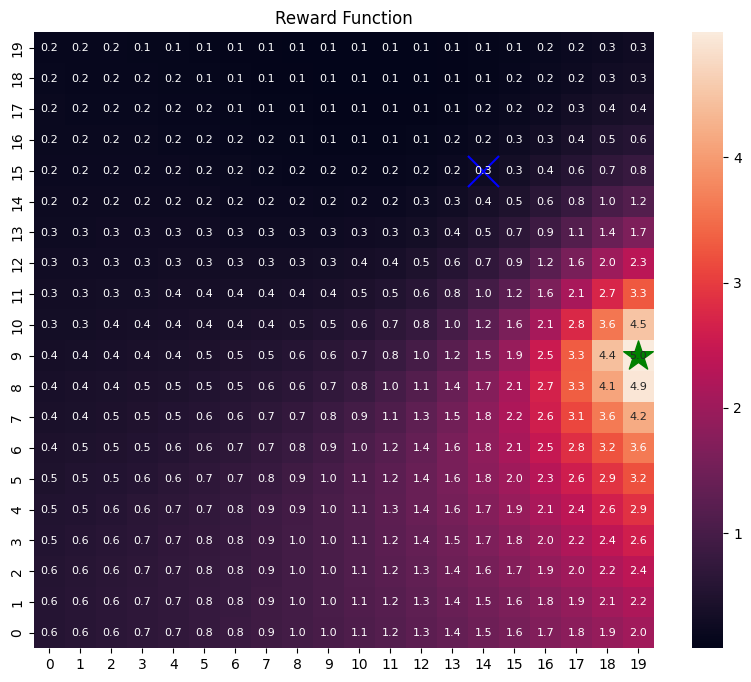

In [12]:
V_grid = np.zeros(R_grid.shape)
V_grid_next = np.zeros(R_grid.shape)

num_iter = 500
for _ in range(num_iter):
    
    V_grid = V_grid_next.copy()

    V_grid_next = np.zeros(R_grid.shape)

    # One iteration of grid update
    for y in range(V_grid.shape[0]):
        for x in range(V_grid.shape[1]):
            
            list_V = []
    
            x_neighbors = [action_dynamics(np.array([y, x]), a) for a in act]
            
            for a in act:
    
                # update for center locations 
                x_next = action_dynamics(np.array([y, x]), a)

                R_plus_V = R_grid[*x_next] + γ * V_grid[*x_next]
    
                prob = (1 - ω_grid[y, x])
    
                sum_val = prob * R_plus_V
    
                # Account for random movement values
                for x_ngbr in x_neighbors:
                    R_plus_V = R_grid[*x_ngbr] + γ * V_grid[*x_ngbr]

                    # equal probability for each of the neighbors based on the current position
                    prob = ω_grid[y, x] / 4 
                
                    sum_val += prob * R_plus_V
                    
                
                list_V.append(sum_val)
                # print(sum_val)
                # break
            V_grid_next[y, x] = max(list_V)

    if np.max(np.abs(V_grid_next - V_grid)) < 1e-6:
        break

            
        

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(V_grid_next, annot=True, annot_kws={'fontsize':8}, ax=ax, fmt='.1f')
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='b', marker='x', label='Storm Eye')
# ax.plot(x_trj[:,0]+0.5, x_trj[:,1]+0.5, linewidth=8)
ax.invert_yaxis()
ax.set_title('Reward Function')

In [13]:
# Find Optimal Policy based on Value
act_grid = np.ones(R_grid.shape) * -1

for i in range(V_grid.shape[0]):
    for j in range(V_grid.shape[1]):
        # i = 9
        # j = 15
        
        a_x_pair = [(a, action_dynamics(np.array([i, j]), a)) for a in act]

        list_a = []
        list_v_diff = []
        for a, x_next in a_x_pair:
            # print(a, x_next)
            V_x = V_grid[i, j]

            V_x_next = V_grid[*x_next]

            list_v_diff.append(V_x_next-V_x)
            list_a.append(a)

        act_grid[i, j] = list_a[np.argmax(list_v_diff)]
        # print(act_grid[i, j], list_v_diff)
    #     break
    # break
    # act_grid[i][j] = np.where(list_v_diff == np.max(list_v_diff))[0]
    # print(np.where(list_v_diff == np.max(list_v_diff))[0])
    

# act_grid

Text(0.5, 1.0, 'Policy')

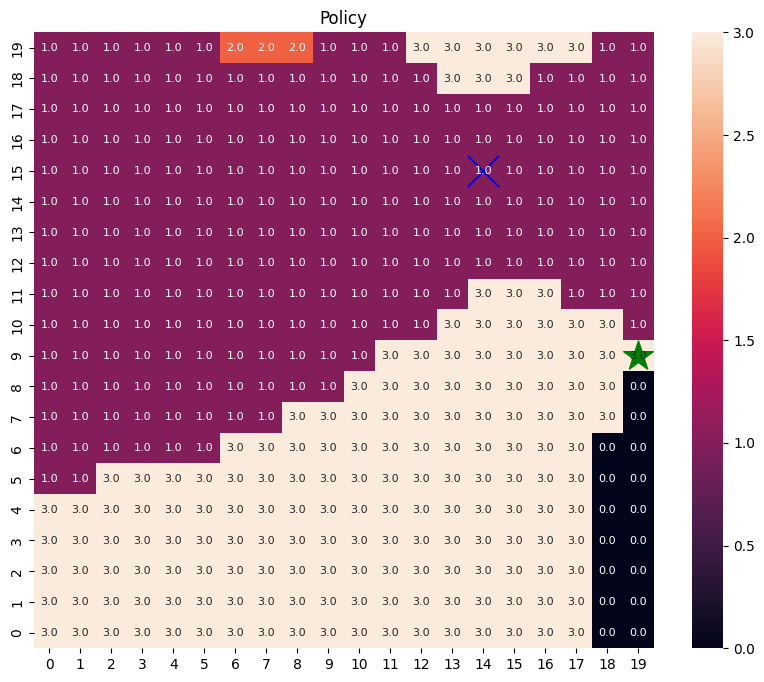

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(act_grid, annot=True, annot_kws={'fontsize':8}, ax=ax, fmt='.1f')
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='b', marker='x', label='Storm Eye')
# ax.plot(x_trj[:,0]+0.5, x_trj[:,1]+0.5, linewidth=8)
ax.invert_yaxis()
ax.set_title('Policy')

Text(0.5, 1.0, 'Policy Heatmap and Tracjectory')

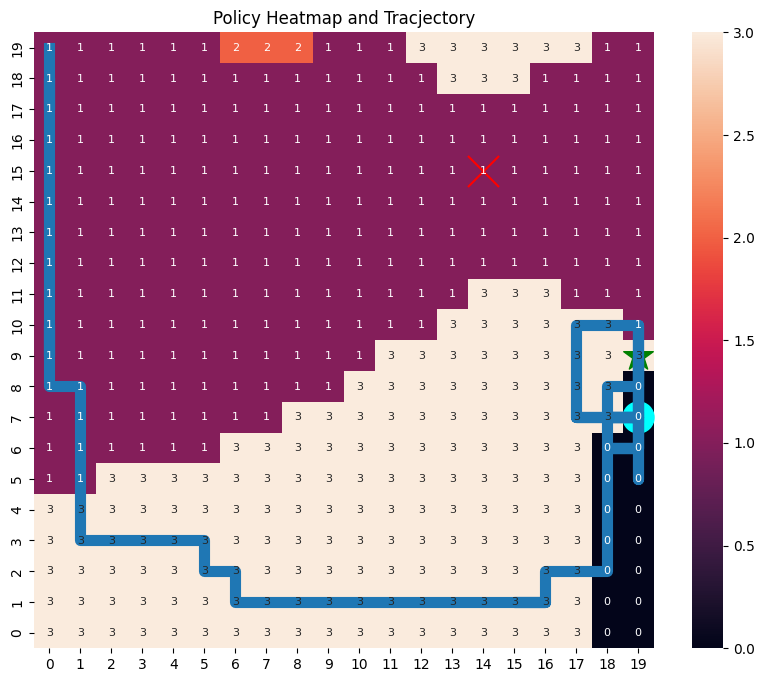

In [17]:
x0 = np.array([19, 0]) #y, x

num_iter = 100

x_trj = np.zeros((num_iter+1, x0.shape[0]), dtype=int)
x_trj[0] = x0

for i in range(num_iter):
    a = int(act_grid[*x_trj[i,:]])
    x_trj[i+1,:] = dynamics(x_trj[i,:], a, ω_grid, n) 
    
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(act_grid, annot=True, annot_kws={'fontsize':8}, ax=ax)
ax.scatter(x_goal[1]+0.5,x_goal[0]+0.5,s=500,c='g', marker='*', label='Goal')
ax.scatter(x_eye[1]+0.5,x_eye[0]+0.5,s=500,c='r', marker='x', label='Storm Eye')
ax.scatter(x_trj[-1,1]+0.5, x_trj[-1,0]+0.5,s=500,c='cyan', marker='o', label='Final Destination')
ax.plot(x_trj[:,1]+0.5, x_trj[:,0]+0.5, linewidth=8)
ax.invert_yaxis()
ax.set_title('Policy Heatmap and Tracjectory')

The policy can be largely divided into three sections. 

In the bottom right corner, we are directly below our goal position. The policy simply drives our position upwards until we hit the destination.

In the bottom half of the grid, the policy tells us to keep going right -- such that we are either hit right into the goal position, or just go up or down along the grid border until we hit the goal state.

In the top half of the grid, the policy tells us to keep doing down until we reach the region where the optimal policy is to go right until we hit the right edge